In [1]:
from __future__ import print_function

import math
import os
import sys
from collections import Counter
from copy import deepcopy
from tqdm import tqdm

import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sqlalchemy import Table, distinct, select, text, types
from sqlalchemy.dialects.oracle import (BFILE, BLOB, CHAR, CLOB, DATE,
                                        DOUBLE_PRECISION, FLOAT, INTERVAL,
                                        LONG, NCLOB, NUMBER, NVARCHAR,
                                        NVARCHAR2, RAW, TIMESTAMP, VARCHAR,
                                        VARCHAR2)
pd.options.display.max_columns = None
pd.options.display.max_rows = None
plt.rc('font',family='SimHei') 
%matplotlib inline

In [2]:
# The argument need to be specified
VERSION = "20230219" # 20221211 will be expired at 20230219
T_LENGTH = 48 # 72, 96, 120

# set the merging minutes
MERGING_MINS = 5 # 60
DATA_PATH = os.path.join('./data/Fuo', VERSION, '{}hours'.format(T_LENGTH))

### 0 - Load the original data and do some neccessary operation

+ replace none with np.nan in time-series data
+ calculate the missing rate of each temporal features and drop the features with high missing rate

In [3]:
# create fold to save the processed data
processed_data_path = os.path.join(DATA_PATH, 'processed')
if not os.path.exists(processed_data_path):
    os.makedirs(processed_data_path)

print("load serial data file!")
serial_data = np.empty([0], dtype=object)
serial_data = np.concatenate((serial_data, np.load(os.path.join(DATA_PATH, 'Serial_feature_{}hrs.npy'.format(T_LENGTH)), allow_pickle=True)))

print("load static continous data!")
static_data_val = np.load(os.path.join(DATA_PATH, 'Static_feature_val.npy'), allow_pickle=True)

print("load static category data!")
static_data_cat = np.load(os.path.join(DATA_PATH, 'Static_feature_cat.npy'), allow_pickle=True)

print("load label data!")
label_data = np.load(os.path.join(DATA_PATH, 'Label.npy'), allow_pickle=True)

N = len(serial_data)
print('# of samples:', N)

load serial data file!
load static continous data!
load static category data!
load label data!
# of samples: 21524


In [4]:
# extract the matrix without vid and time-intervals seconds away from admission
X_raw = np.array([np.array(xx)[:, :-2] for xx in serial_data]) # array([N * array([t * []], dtype=object)])
tsraw = np.array([np.array(xx)[:, -2] for xx in serial_data])
vid_raw =np.array([np.array(xx)[0, -1] for xx in serial_data])
X_raw = np.array([np.array(xx.tolist(), dtype=float) for xx in X_raw]) # array([N * array([t * []], dtype=float)]) change data type
tsraw = np.array([np.array(xx.tolist(), dtype=float) for xx in tsraw])

# replace None with np.nan
for i_n in tqdm(range(N)):
    for i_t in range(len(X_raw[i_n])):
        for i_d in range(len(X_raw[i_n][i_t])):
            if X_raw[i_n][i_t][i_d] is None:
                X_raw[i_n][i_t][i_d] = np.nan

# concatenate all the N array into a big matrix, and the number of columns equals 7 here, to calculate the missing ratio of each serial variable
X_raw_all = np.concatenate(X_raw)

# calculate the missing rate of each column
missing_rate = np.sum(np.isnan(X_raw_all), axis=0) * 1.0 / X_raw_all.shape[0]
print("The missing rate of column (体温, 呼吸, 脉搏, 舒张压, 收缩压, SPO2, time_gap_zero) are respectively {}".format(missing_rate.tolist()))
# set the threshold to drop the column
keep_val_idx = missing_rate < 1-5e-4
keep_val_idx_list = np.where(keep_val_idx)
X_raw_all_kept = X_raw_all[:,keep_val_idx]
X_raw_kept = np.array([xx[:, keep_val_idx] for xx in X_raw])

print('Done!')

/home/zju/anaconda3/envs/hie_attn/lib/python3.6/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/home/zju/anaconda3/envs/hie_attn/lib/python3.6/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until
/home/zju/anaconda3/envs/hie_attn/lib/python3.6/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or 

The missing rate of column (体温, 呼吸, 脉搏, 舒张压, 收缩压, SPO2, time_gap_zero) are respectively [0.29594588400660027, 0.29718343213347187, 0.34211712399926664, 0.7048447717411233, 0.7048447717411233, 0.6988098148261321, 0.0]
Done!


/home/zju/anaconda3/envs/hie_attn/lib/python3.6/site-packages/ipykernel_launcher.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


### 1 - Plot the distribution of time-series data and delete the outliers

+ detect the outlier and made the strategy to process the outlier
+ replot the distribution of time-series data after processing
+ this part can reference [https://zhuanlan.zhihu.com/p/93555997]

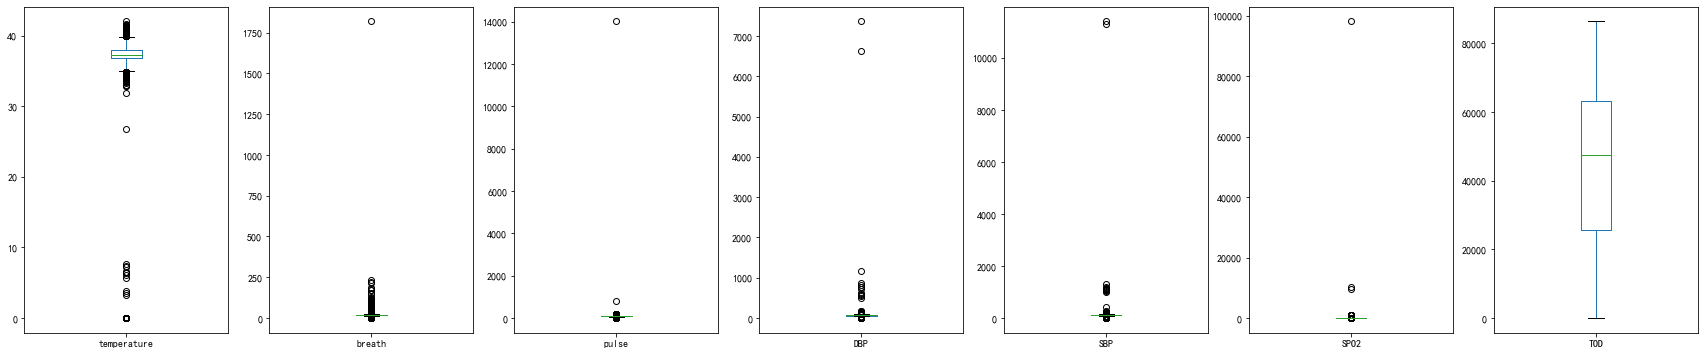

In [5]:
# detect the outliers
ts_columns = ["temperature", "breath", "pulse", "DBP", "SBP", "SPO2", "TOD"]

df_X_raw = pd.DataFrame(X_raw_all_kept, columns=ts_columns)
df_X_raw.plot(kind='box', 
              subplots=True, 
              layout=(1,7),
              sharex=False,
              sharey=False, 
              figsize=(30,6))
plt.savefig(os.path.join(DATA_PATH, '0-Boxplot of temporal data ({0}hours)-before process.png'.format(str(T_LENGTH))), bbox_inches='tight', dpi=400)
plt.show()

In [6]:
# calculate the mean and std
mean = df_X_raw.mean()
std = df_X_raw.std()
range_low = mean - 3 * std
range_high = mean + 3 * std

stat_tsdata = df_X_raw.describe()
np.save(os.path.join(DATA_PATH, '0-describe of temporal data ({0}hours)-before process.npy'.format(str(T_LENGTH))), stat_tsdata)
stat_tsdata

,temperature,breath,pulse,DBP,SBP,SPO2,TOD
count,184327.00000,184003.000000,172239.000000,77274.000000,77274.000000,78854.000000,261808.000000
mean,37.33732,18.895161,85.060215,69.742138,116.625657,99.018908,45160.038914
std,2.00977,5.250899,36.739639,38.172337,61.347426,352.621746,20309.590940
min,0.00000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000
25%,36.80000,18.000000,75.000000,61.000000,103.000000,97.000000,25702.750000
50%,37.30000,18.000000,83.000000,69.000000,114.000000,98.000000,47545.000000
75%,38.00000,20.000000,93.000000,77.000000,127.000000,99.000000,63231.000000
max,42.00000,1818.000000,14010.000000,7360.000000,11399.000000,98105.000000,86397.000000


df_X_raw[df_X_raw["SPO2"] > range_high['SPO2']]

df_X_raw[df_X_raw["SPO2"] < range_low['SPO2']]

In [7]:
# the strategy below is made by myself
X_raw_new = np.empty([N], dtype=object)
tsraw_new = np.empty([N], dtype=object)
vid_raw_new = []
outlier_count = 0
for i in tqdm(range(N)):
    X_raw_new[i] = []
    tsraw_new[i] = []
    for t in range(X_raw[i].shape[0]):
        """
        The numeric data like 20, 50, 10, 100 are based on my inspection
        """
        # temperature < mean-3*sigma or temperature > mean+3*sigma
        if (X_raw[i][t][0] < range_low['temperature']) or (X_raw[i][t][0] > range_high['temperature']):
            X_raw[i][t][0] = np.nan
        # breath < mean-3*sigma or breath > mean+3*sigma
        if (X_raw[i][t][1] < range_low['breath']) or (X_raw[i][t][1] > 200):
            X_raw[i][t][1] = np.nan
        # pulse < mean-3*sigma or pulse > mean+3*sigma
        if (X_raw[i][t][2] < range_low['pulse']) or (X_raw[i][t][2] > range_high['pulse']):
            X_raw[i][t][2] = np.nan
        # DBP < mean-3*sigma or DBP > mean+3*sigma
        if (X_raw[i][t][3] < 20) or (X_raw[i][t][3] > range_high['DBP']):
            X_raw[i][t][3] = np.nan
        # SBP < mean-3*sigma or SBP > mean+3*sigma
        if (X_raw[i][t][4] < 50) or (X_raw[i][t][4] > range_high['SBP']):
            X_raw[i][t][4] = np.nan
        # SPO2 < mean-3*sigma or SPO2 > mean+3*sigma
        if (X_raw[i][t][5] < 10) or (X_raw[i][t][5] > 100):
            X_raw[i][t][5] = np.nan

        # delete this time-step record
        if np.all(np.isnan(X_raw[i][t][:-1])):
            outlier_count += 1
            continue
        else:
            X_raw_new[i].append(X_raw[i][t])
            tsraw_new[i].append(tsraw[i][t])
    # delete this whole vid record
    if  len(X_raw_new[i]) != 0:
        vid_raw_new.append(vid_raw[i])

print("{} outlier records have been deleted".format(outlier_count))
vid_raw_new = np.asarray(vid_raw_new)
if vid_raw_new.shape[0] != vid_raw.shape[0]:
    print("{} outlier vids have been deleted".format(vid_raw.shape[0]-vid_raw_new.shape[0]))
    assert [False if len(x)==0 else True for x in X_raw_new] == [False if len(x)==0 else True for x in tsraw_new], \
        "There is an error after outlier process!!!!!!"
    sample_index = [False if len(x)==0 else True for x in X_raw_new]
    X_raw_new = X_raw_new[sample_index]
    tsraw_new = tsraw_new[sample_index]

X_raw_new = np.array([np.array(xx, dtype=float) for xx in X_raw_new]) # array([N * array([t * []], dtype=float)]) change data type
tsraw_new = np.array([np.array(xx, dtype=float) for xx in tsraw_new])

X_raw_all_new = np.concatenate(X_raw_new)

# resample the other data based on the "sample_index"
static_data_val = static_data_val[sample_index]
static_data_cat = static_data_cat[sample_index]
label_data = label_data[sample_index]
assert static_data_val.shape[0]==static_data_cat.shape[0]==label_data.shape[0]==X_raw_new.shape[0]==tsraw_new.shape[0]==vid_raw_new.shape[0],\
    "The resampled data is not aligned!!!!!!"
N = len(X_raw_new)
print('# of samples:', N)

100%|██████████| 21524/21524 [00:12<00:00, 1752.18it/s]
/home/zju/anaconda3/envs/hie_attn/lib/python3.6/site-packages/ipykernel_launcher.py:53: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


433 outlier records have been deleted
3 outlier vids have been deleted
# of samples: 21521


/home/zju/anaconda3/envs/hie_attn/lib/python3.6/site-packages/ipykernel_launcher.py:54: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


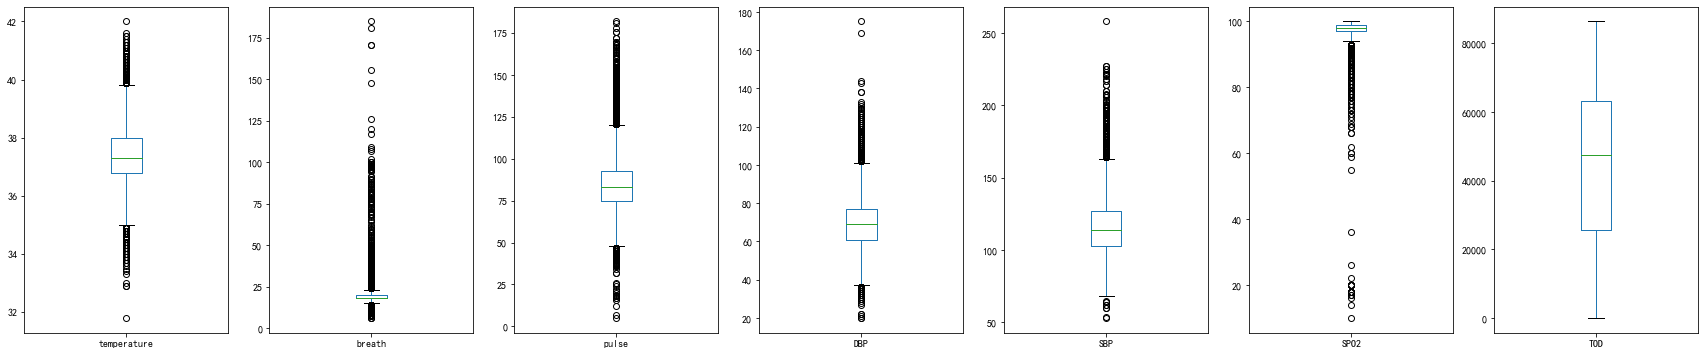

In [8]:
# detect the outliers
ts_columns = ["temperature", "breath", "pulse", "DBP", "SBP", "SPO2", "TOD"]

df_X_raw = pd.DataFrame(X_raw_all_new, columns=ts_columns)
df_X_raw.plot(kind='box', 
              subplots=True, 
              layout=(1,7),
              sharex=False,
              sharey=False, 
              figsize=(30,6))
plt.savefig(os.path.join(DATA_PATH, '0-Boxplot of temporal data ({0}hours)-after process.png'.format(str(T_LENGTH))), bbox_inches='tight', dpi=400)
plt.show()

In [9]:
stat_tsdata = df_X_raw.describe()
np.save(os.path.join(DATA_PATH, '0-describe of temporal data ({0}hours)-after process.npy'.format(str(T_LENGTH))), stat_tsdata)
stat_tsdata

,temperature,breath,pulse,DBP,SBP,SPO2,TOD
count,183887.000000,183979.000000,172236.000000,77224.000000,77217.000000,78830.000000,261375.000000
mean,37.426131,18.884011,84.974508,69.502163,116.235259,97.441456,45162.470952
std,0.859326,3.045752,14.863785,12.066302,18.235943,2.323355,20309.610059
min,31.800000,6.000000,5.000000,20.000000,53.000000,10.000000,0.000000
25%,36.800000,18.000000,75.000000,61.000000,103.000000,97.000000,25710.000000
50%,37.300000,18.000000,83.000000,69.000000,114.000000,98.000000,47545.000000
75%,38.000000,20.000000,93.000000,77.000000,127.000000,99.000000,63231.500000
max,42.000000,185.000000,182.000000,175.000000,258.000000,100.000000,86397.000000


### 2 - Inspect the distribution of observations, do merging operation and generate deltaT
+ decide the merging minutes in terms of observations distributions

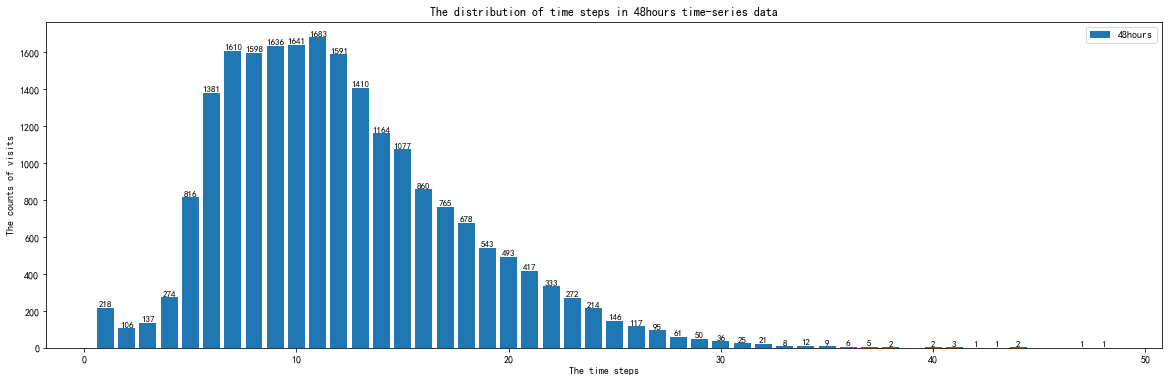

In [10]:
# mapping the vids into index
map_vids_list = {}
index = 0
for i in range(len(vid_raw_new)):
    if vid_raw_new[i] not in map_vids_list:
        map_vids_list[vid_raw_new[i]] = index
        index += 1

# calculate the distribution of observations
time_steps = []
for i in range(len(X_raw_new)):
    time_steps.append(X_raw_new[i].shape[0])

# count the time steps
ts_count = Counter(time_steps)
# resort the "ts_count" in terms of time steps
ts_count_sorted = sorted(ts_count.items(), key=lambda x: x[0], reverse=False)
# transform into dict
ts_count_sorted_dt = {}
for step ,count in ts_count_sorted:
    ts_count_sorted_dt[step] = count

# transform into dataframe
df = pd.DataFrame.from_dict(ts_count_sorted_dt, orient='index',columns=['counts of visits'])
df = df.reset_index().rename(columns = {'index':'time steps'})

# plot and save
plt.figure(figsize=(20,6))
p1 = plt.bar(df['time steps'], df['counts of visits'], label='{}hours'.format(str(T_LENGTH).title()))
for a, b in zip(df['time steps'], df['counts of visits']):
        plt.text(a, b + 0.05, '%.0f' % b, ha='center', va='bottom', fontsize=9)
plt.title('The distribution of time steps in {0}hours time-series data'.format(str(T_LENGTH).title()))
plt.xlabel('The time steps')
plt.ylabel('The counts of visits')
plt.legend()
plt.savefig(os.path.join(DATA_PATH, '1-Distribution_of_time_steps({0}hours).png'.format(str(T_LENGTH))), bbox_inches='tight', dpi=400)
plt.show()
plt.close()

/home/zju/anaconda3/envs/hie_attn/lib/python3.6/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


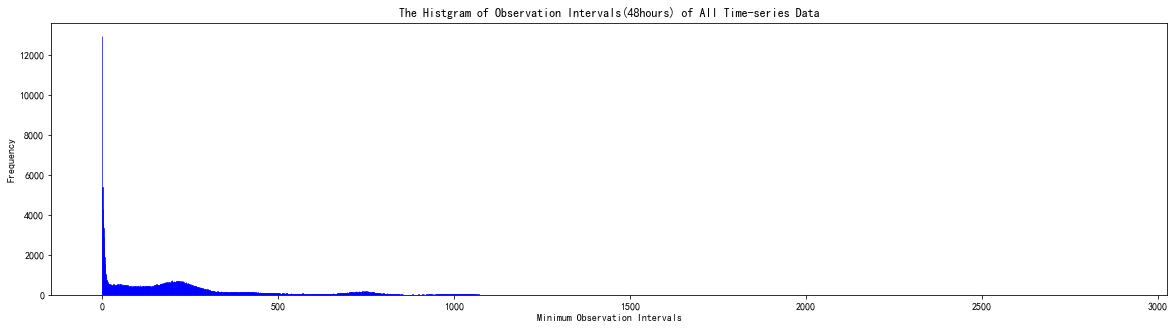

In [11]:
# calculate the minimum observation gap
tsraw_gap = []
for i in range(len(tsraw_new)):
    tsraw_gap.append(tsraw_new[i][1:]-tsraw_new[i][:-1])

tsraw_gap_arr = np.array([xx for xx in tsraw_gap])
tsraw_gap_all = np.concatenate(tsraw_gap_arr).tolist()
tsraw_gap_all.sort()
# transform into min unit
tsraw_gap_all = [ x / 60 for x in tsraw_gap_all]

# plot the hist of miminum observation intervals
plt.figure(figsize=(20,5))
# bins=T_LENGTH*60, every bin represents one minute.
plt.hist(tsraw_gap_all, bins=T_LENGTH * 60, facecolor="blue", edgecolor="blue", alpha=0.7, label='{}hours'.format(str(T_LENGTH).title()))
plt.xlabel("Minimum Observation Intervals")
plt.ylabel("Frequency")
plt.title("The Histgram of Observation Intervals({}hours) of All Time-series Data".format(T_LENGTH))
plt.savefig(os.path.join(DATA_PATH, '1-The histgram of observation intervals({}hours) of all time-series data.png'.format(T_LENGTH)), bbox_inches='tight', dpi=400)
plt.show()

# from the figure below, we can see that there are 12000 observation intervals in 1 minute, 
# so we decide to merge the obsevations with 5 minutes.

In [12]:
processed_data_path_raw = os.path.join(processed_data_path, 'raw')
if not os.path.exists(processed_data_path_raw):
    os.makedirs(processed_data_path_raw)

print('Get mean and std for tsdata!')
n_serial_var = X_raw_all_new.shape[1]
tsdata_mean = np.nanmean(X_raw_all_new, axis=0)
tsdata_std = np.nanstd(X_raw_all_new, axis=0)
del X_raw_all_new

# get ep data with mask and deltaT
# 0-mean, 1-std, merge observations within 5 mins
print('Get X_new and t_new!')
X_new = np.empty([N], dtype=object)
t_new = np.empty([N], dtype=object)
for i in tqdm(range(N)):
    tsraw_new[i] = tsraw_new[i].flatten()
    t = 0
    X_new[i] = []
    t_new[i] = []
    while t < len(tsraw_new[i]):
        t1 = t + 1
        while t1 < len(tsraw_new[i]) and tsraw_new[i][t1] - tsraw_new[i][t] <= MERGING_MINS * 60:
            t1 += 1

        # if choose to normalize the X_new here
        # X_new[i].append((np.nanmean(X_raw_kept[i][t:t1,:], axis=0) - tsdata_mean) / tsdata_std)
        
        # we do not normalize here!!!!!!!
        X_new[i].append(
            np.nanmean(X_raw_new[i][t:t1,:], axis=0)
        )
        t_new[i].append(int((tsraw_new[i][t1-1]+tsraw_new[i][t])/2))
        t = t1
print('Done!')

print('Get X_t, mask, etc!')
X_t = np.empty([N], dtype=object)       #N*[t*d]
X_t_mask = np.empty([N], dtype=object)  #N*[t*d]
T_t = t_new                             #N*[t]
T_t_rel = np.empty([N], dtype=object) # relative value
deltaT_t = np.empty([N], dtype=object)  #N*[t*d]
for i in tqdm(range(N)):
    # concatenate all t step of one visit into a [t*d] array
    X_t[i] = np.vstack(X_new[i])
    # calc the masking array, True = exists, False = missing
    X_t_mask[i] = 1 - np.isnan(X_t[i]).astype('int8')
    # set the np.nan in X_t to 0
    X_t[i][np.isnan(X_t[i])] = 0
    # get the deltaT_t
    deltaT_t[i] = np.zeros_like(X_t[i], dtype=int)
    # set the first row equals 0
    deltaT_t[i][0,:] = 0
    for i_t in range(1, len(T_t[i])):
        deltaT_t[i][i_t, :] = T_t[i][i_t] - T_t[i][i_t-1] + (1-X_t_mask[i][i_t-1,:]) * deltaT_t[i][i_t-1,:]
    # start from 0
    T_t_rel[i] = np.asarray(T_t[i]) - T_t[i][0]
print('Done!')

Get mean and std for tsdata!
Get X_new and t_new!


100%|██████████| 21521/21521 [00:14<00:00, 1486.25it/s]


Done!
Get X_t, mask, etc!


100%|██████████| 21521/21521 [00:01<00:00, 11029.11it/s]

Done!


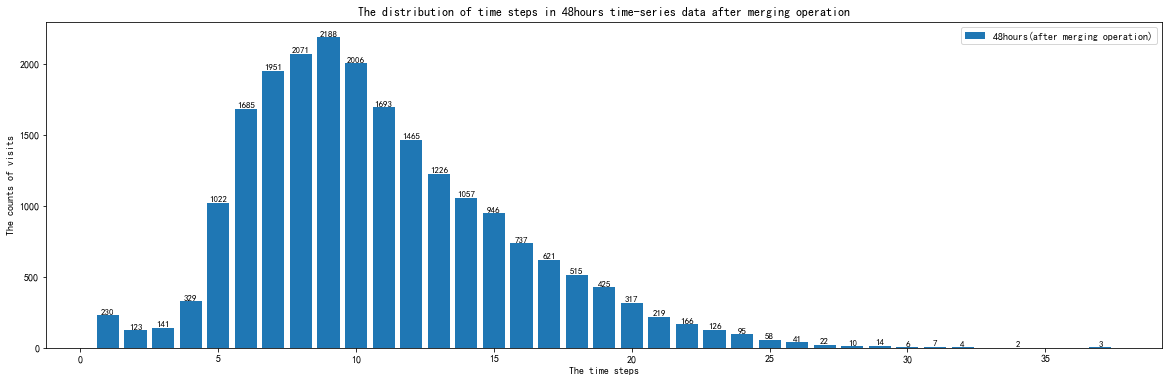

In [13]:
# calculate the distribution of observations after merging
time_steps = []
for i in range(len(X_t)):
    time_steps.append(X_t[i].shape[0])

# count the time steps
ts_count = Counter(time_steps)
# resort the "ts_count" in terms of time steps
ts_count_sorted = sorted(ts_count.items(), key=lambda x: x[0], reverse=False)
# transform into dict
ts_count_sorted_dt = {}
for step ,count in ts_count_sorted:
    ts_count_sorted_dt[step] = count

# transform into dataframe
df = pd.DataFrame.from_dict(ts_count_sorted_dt, orient='index',columns=['counts of visits'])
df = df.reset_index().rename(columns = {'index':'time steps'})

# plot and save
plt.figure(figsize=(20,6))
p1 = plt.bar(df['time steps'], df['counts of visits'], label='{}hours(after merging operation)'.format(str(T_LENGTH).title()))
for a, b in zip(df['time steps'], df['counts of visits']):
        plt.text(a, b + 0.05, '%.0f' % b, ha='center', va='bottom', fontsize=9)
plt.title('The distribution of time steps in {0}hours time-series data after merging operation'.format(str(T_LENGTH).title()))
plt.xlabel('The time steps')
plt.ylabel('The counts of visits')
plt.legend()
plt.savefig(os.path.join(DATA_PATH, '1-Distribution_of_time_steps({0}hours) after merging operation.png'.format(str(T_LENGTH))), bbox_inches='tight', dpi=400)
plt.show()
plt.close()

### 2 - Do necessary operation on time-invariant data and save the above data

In [14]:
print('Process the numerical and categorical data!')
static_data_cat[static_data_cat == ''] = '0'
oe = preprocessing.OrdinalEncoder()
static_data_cat = oe.fit_transform(static_data_cat)

ohe = preprocessing.OneHotEncoder()
static_data_cat_onehot = ohe.fit_transform(static_data_cat).toarray()

static_data_val[static_data_val == ''] = np.nan
static_data_val[static_data_val == '52.0.0'] = 52
static_data_val = static_data_val.astype(float)
print('Done!')

Process the numerical and categorical data!
Done!


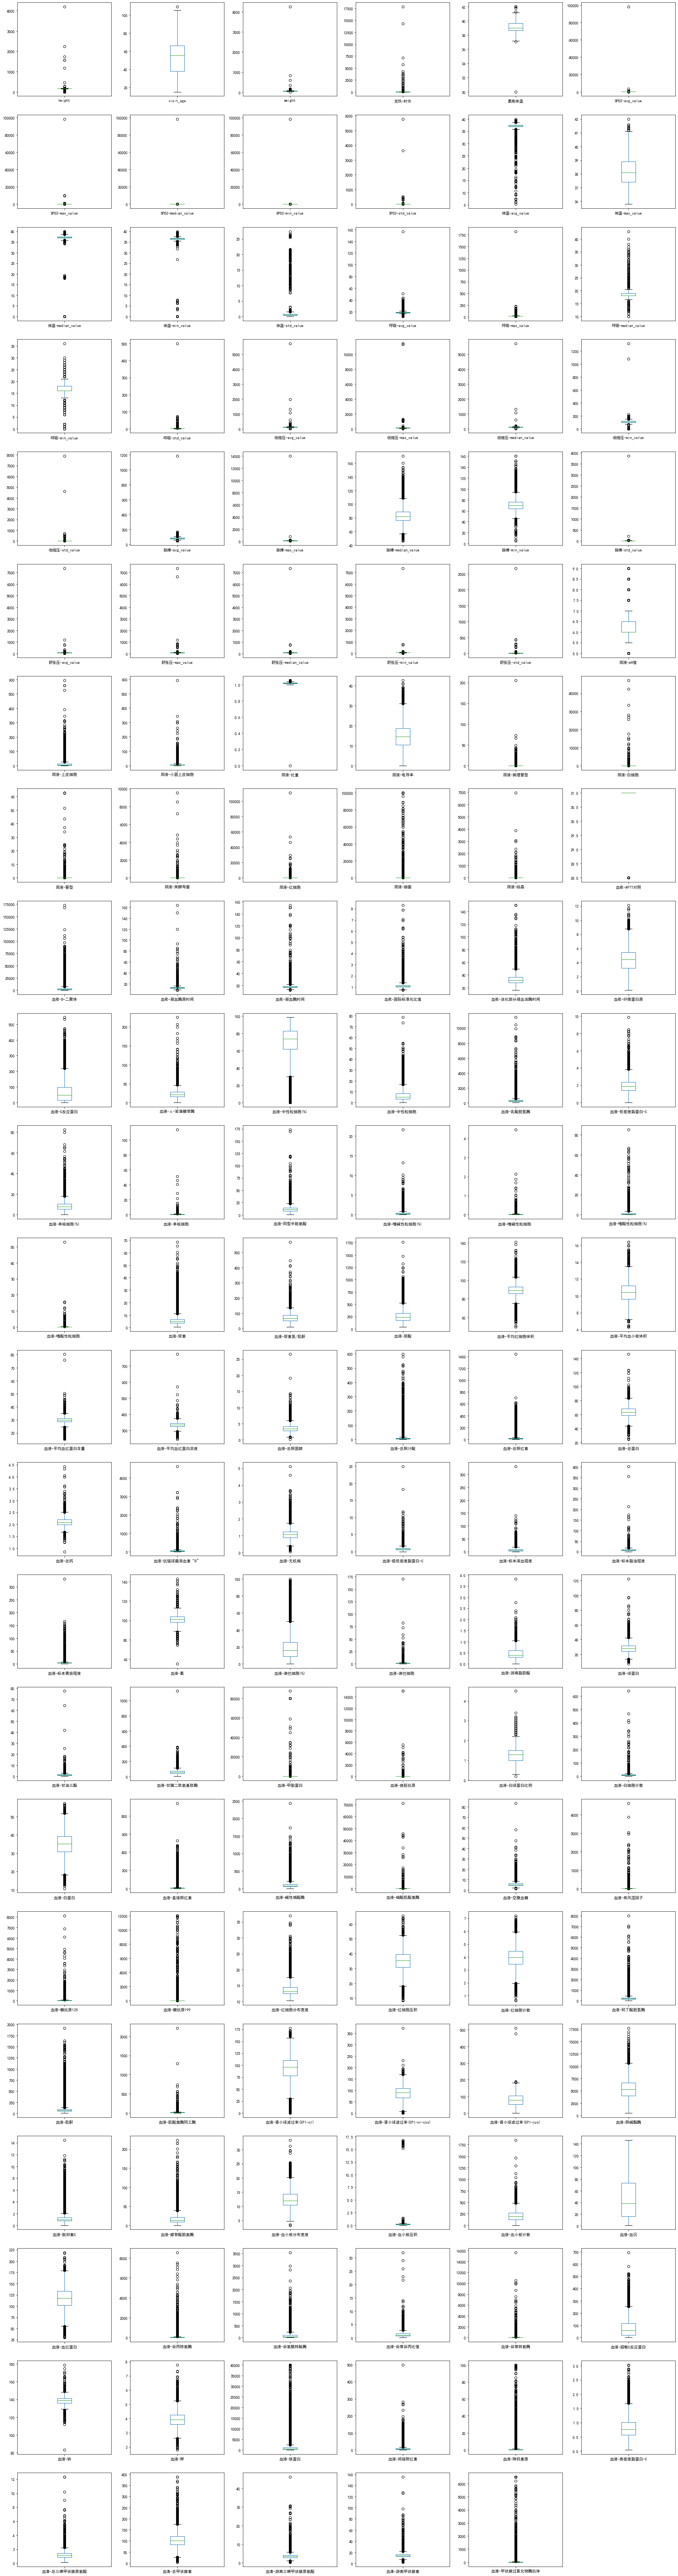

In [15]:
# detect the outliers
# load the feature name of static continuous data
item_dict = np.load(os.path.join(DATA_PATH, "map_item_index.npy"), allow_pickle=True).tolist()
static_val_columns = []
for key, value in item_dict.items():
    static_val_columns.append(key)

static_val_columns = static_val_columns[53:]

df_X_val = pd.DataFrame(static_data_val, columns=static_val_columns)
df_X_val.plot(kind='box', 
              subplots=True, 
              layout=(23,6),
              sharex=False,
              sharey=False, 
              figsize=(30,120))
plt.savefig(os.path.join(DATA_PATH, '2-Boxplot of static continous data ({0}hours)-before process.png'.format(str(T_LENGTH))), bbox_inches='tight', dpi=400)
plt.show()

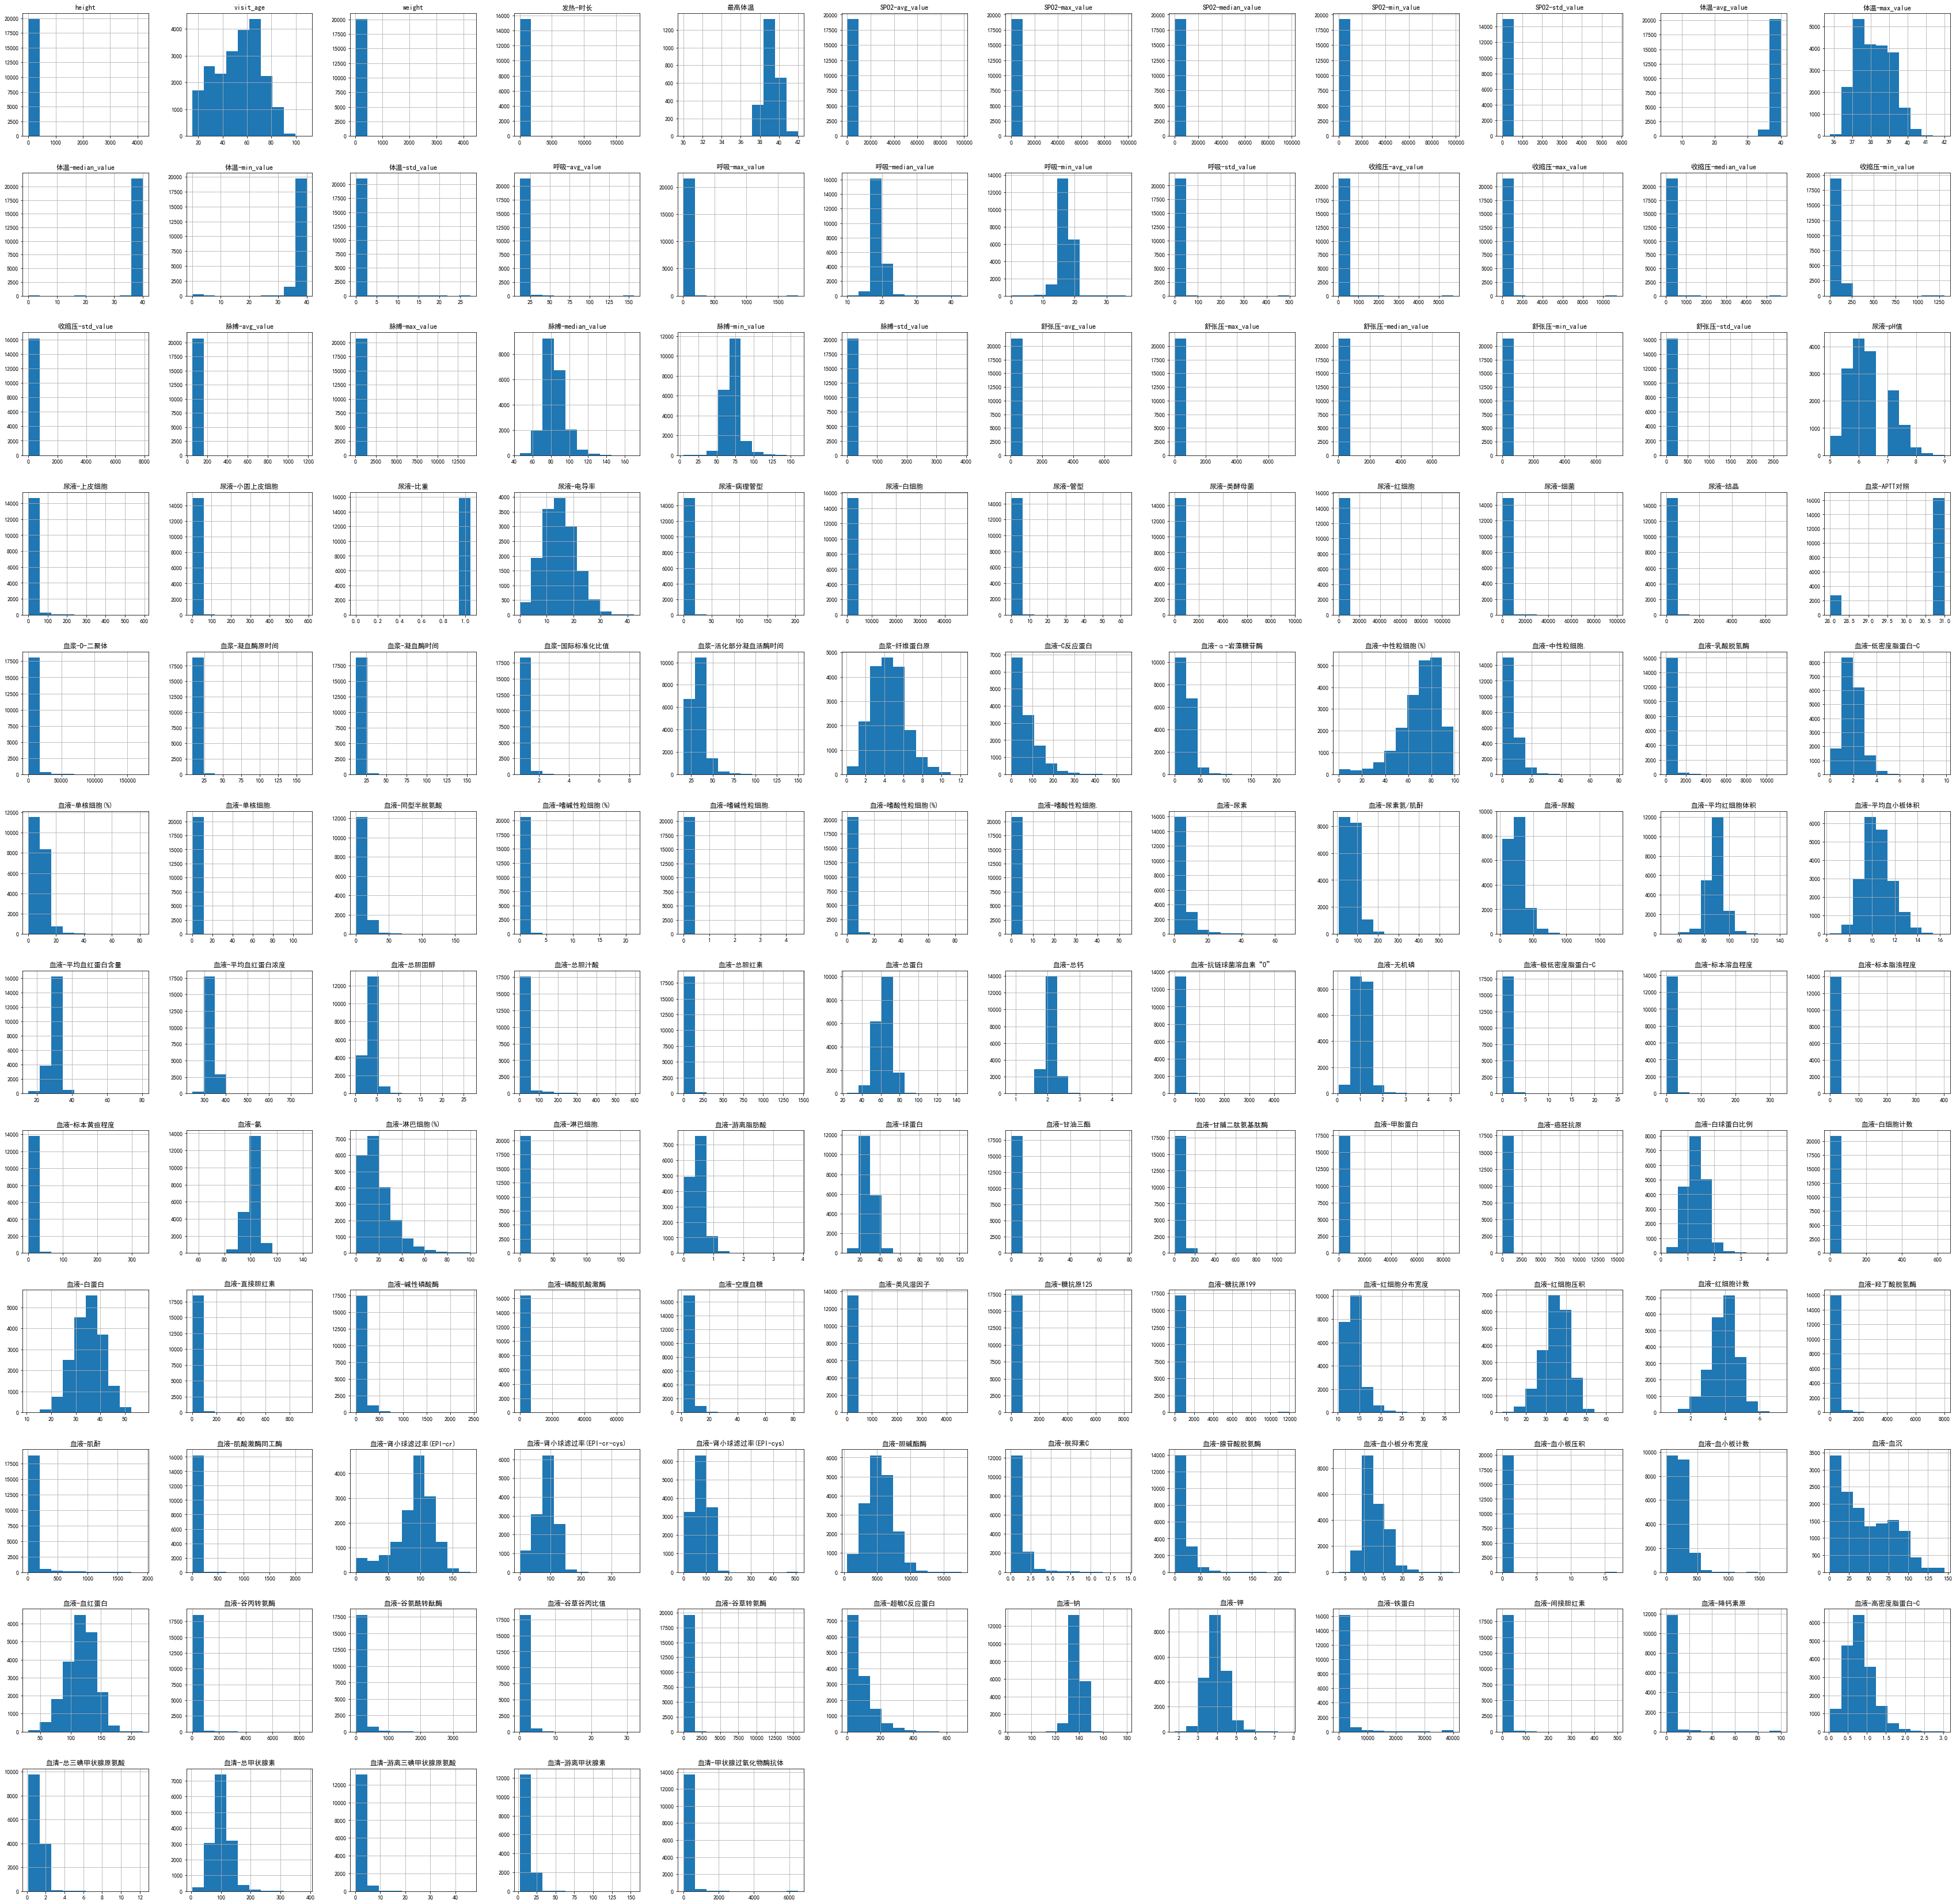

In [16]:
# plot the his
df_X_val.hist(figsize=(60,60))
plt.savefig(os.path.join(DATA_PATH, '2-Hisplot of static continous data ({0}hours)-before process.png'.format(str(T_LENGTH))), bbox_inches='tight', dpi=400)
plt.show()

# plot correlation plot(!!!!cost a lot of time)
# scatter_matrix(df_X_val, figsize=(60,60))
# plt.savefig(os.path.join(DATA_PATH, '2-scatter_matrix of static continous data ({0}hours)-before process.png'.format(str(T_LENGTH))), bbox_inches='tight', dpi=400)
# plt.show()

In [17]:
# calculate the mean and std
mean = df_X_val.mean()
std = df_X_val.std()
range_low = mean - 3 * std
range_high = mean + 3 * std

stat_data = df_X_val.describe()
np.save(os.path.join(DATA_PATH, '2-describe of static continous data ({0}hours)-before process.npy'.format(str(T_LENGTH))), stat_data)
stat_data

,height,visit_age,weight,发热-时长,最高体温,SPO2-avg_value,SPO2-max_value,SPO2-median_value,SPO2-min_value,SPO2-std_value,体温-avg_value,体温-max_value,体温-median_value,体温-min_value,体温-std_value,呼吸-avg_value,呼吸-max_value,呼吸-median_value,呼吸-min_value,呼吸-std_value,收缩压-avg_value,收缩压-max_value,收缩压-median_value,收缩压-min_value,收缩压-std_value,脉搏-avg_value,脉搏-max_value,脉搏-median_value,脉搏-min_value,脉搏-std_value,舒张压-avg_value,舒张压-max_value,舒张压-median_value,舒张压-min_value,舒张压-std_value,尿液-pH值,尿液-上皮细胞,尿液-小圆上皮细胞,尿液-比重,尿液-电导率,尿液-病理管型,尿液-白细胞,尿液-管型,尿液-类酵母菌,尿液-红细胞,尿液-细菌,尿液-结晶,血浆-APTT对照,血浆-D-二聚体,血浆-凝血酶原时间,血浆-凝血酶时间,血浆-国际标准化比值,血浆-活化部分凝血活酶时间,血浆-纤维蛋白原,血液-C反应蛋白,血液-α-岩藻糖苷酶,血液-中性粒细胞(%),血液-中性粒细胞.,血液-乳酸脱氢酶,血液-低密度脂蛋白-C,血液-单核细胞(%),血液-单核细胞.,血液-同型半胱氨酸,血液-嗜碱性粒细胞(%),血液-嗜碱性粒细胞.,血液-嗜酸性粒细胞(%),血液-嗜酸性粒细胞.,血液-尿素,血液-尿素氮/肌酐,血液-尿酸,血液-平均红细胞体积,血液-平均血小板体积,血液-平均血红蛋白含量,血液-平均血红蛋白浓度,血液-总胆固醇,血液-总胆汁酸,血液-总胆红素,血液-总蛋白,血液-总钙,血液-抗链球菌溶血素“O”,血液-无机磷,血液-极低密度脂蛋白-C,血液-标本溶血程度,血液-标本脂浊程度,血液-标本黄疸程度,血液-氯,血液-淋巴细胞(%),血液-淋巴细胞.,血液-游离脂肪酸,血液-球蛋白,血液-甘油三酯,血液-甘脯二肽氨基肽酶,血液-甲胎蛋白,血液-癌胚抗原,血液-白球蛋白比例,血液-白细胞计数,血液-白蛋白,血液-直接胆红素,血液-碱性磷酸酶,血液-磷酸肌酸激酶,血液-空腹血糖,血液-类风湿因子,血液-糖抗原125,血液-糖抗原199,血液-红细胞分布宽度,血液-红细胞压积,血液-红细胞计数,血液-羟丁酸脱氢酶,血液-肌酐,血液-肌酸激酶同工酶,血液-肾小球滤过率(EPI-cr),血液-肾小球滤过率(EPI-cr-cys),血液-肾小球滤过率(EPI-cys),血液-胆碱酯酶,血液-胱抑素C,血液-腺苷酸脱氨酶,血液-血小板分布宽度,血液-血小板压积,血液-血小板计数,血液-血沉,血液-血红蛋白,血液-谷丙转氨酶,血液-谷氨酰转酞酶,血液-谷草谷丙比值,血液-谷草转氨酶,血液-超敏C反应蛋白,血液-钠,血液-钾,血液-铁蛋白,血液-间接胆红素,血液-降钙素原,血液-高密度脂蛋白-C,血清-总三碘甲状腺原氨酸,血清-总甲状腺素,血清-游离三碘甲状腺原氨酸,血清-游离甲状腺素,血清-甲状腺过氧化物酶抗体
count,19841.000000,21521.000000,20026.000000,15535.000000,2397.000000,19254.000000,19254.000000,19254.000000,19254.000000,14954.000000,21520.000000,21520.000000,21520.000000,21520.000000,21300.000000,21521.000000,21521.000000,21521.000000,21521.000000,21266.000000,21413.000000,21413.000000,21413.000000,21413.000000,16155.000000,20711.000000,20711.000000,20711.000000,20711.000000,20248.000000,21413.000000,21413.000000,21413.000000,21413.000000,16155.000000,15920.000000,15057.000000,15070.000000,15874.000000,15070.000000,15026.000000,15392.000000,14795.000000,15032.000000,15357.000000,15050.000000,15026.000000,19060.000000,18630.000000,19063.000000,19058.000000,19062.000000,19054.000000,19056.000000,12981.000000,17934.000000,20872.000000,20798.000000,16418.000000,18078.000000,20859.000000,20794.000000,13754.000000,20822.000000,20803.000000,20825.000000,20799.000000,19968.000000,18198.000000,19953.000000,20908.000000,19993.000000,20907.000000,20908.000000,18144.000000,18497.000000,18790.000000,18791.000000,18976.000000,13604.000000,18976.000000,18069.000000,14046.000000,14046.000000,14046.00000,20119.000000,20873.000000,20799.000000,13754.000000,18782.000000,18144.000000,18502.000000,17438.000000,17435.000000,18782.000000,20911.000000,18791.000000,18788.000000,18765.000000,16386.000000,18030.000000,13608.000000,17348.000000,17433.000000,20884.000000,20908.000000,20908.000000,16386.000000,19969.000000,16261.000000,14685.000000,13156.000000,13157.000000,18499.000000,15083.000000,17887.000000,19993.000000,19994.000000,20896.000000,13858.000000,20909.000000,18790.000000,18765.000000,18756.000000,19726.000000,13268.000000,20119.000000,20112.000000,17406.000000,18781.000000,12488.000000,18100.000000,13939.000000,14479.000000,13927.000000,14469.000000,14143.000000
mean,164.429464,52.749965,61.028014,35.895140,39.163955,102.795765,105.023060,102.562299,101.140231,2.236867,37.148188,38.159192,37.163788,36.031076,0.777855,18.800728,21.638767,18.664560,16.608150,1.764226,117.031487,126.759492,116.587680,108.523841,10.922869,83.895139,99.980928,83.212834,70.449679,10.360193,70.704527,77.252277,70.510741,64.710830,7.410558,6.282443,11.120708,5.980053,1.016488,14.674592,0.454279,59.643521,0.175429,10.787194,93.534792,503.842704,8.454858,30.567156,3407.375631,13.003877,17.945713,1.125509,33.107337,4.440263,65.581175,23.029174,70.346383,6.411627,337.733829,1.922290,8.391836,0.661625,12.035786,0.339991,0.025687,1.299121,0.099334,5.955700,71.850214,259.575402,89.020887,10.488301,29.710910,333.676296,3.557226,14.360275,18.650788,63.32250

In [18]:
# re-calculate the stat of time-series data
ts_stat = np.empty([N], dtype=object)
for i in tqdm(range(N)):
    ts_stat[i] = []
    ts_stat[i].append(np.nanmean(X_raw_new[i], axis=0))
    ts_stat[i].append(np.nanmax(X_raw_new[i], axis=0))
    ts_stat[i].append(np.nanmedian(X_raw_new[i], axis=0))
    ts_stat[i].append(np.nanmin(X_raw_new[i], axis=0))
    ts_stat[i].append(np.nanstd(X_raw_new[i], axis=0))

ts_stat = np.array([np.array(xx, dtype=float) for xx in ts_stat])

# 由于之前对时序数据中的异常值进行了处理，因此此处对其统计资料特征对应做更新
# order-->"temperature", "breath", "pulse", "DBP", "SBP", "SPO2", "TOD"

# 体温-avg_value	体温-max_value	体温-median_value	体温-min_value	体温-std_value
static_data_val[:, 10:15] = ts_stat[:, :, 0]
# 呼吸-avg_value	呼吸-max_value	呼吸-median_value	呼吸-min_value	呼吸-std_value
static_data_val[:, 15:20] = ts_stat[:, :, 1]
# 脉搏-avg_value	脉搏-max_value	脉搏-median_value	脉搏-min_value	脉搏-std_value
static_data_val[:, 25:30] = ts_stat[:, :, 2]
# 舒张压-avg_value	舒张压-max_value	舒张压-median_value	舒张压-min_value	舒张压-std_value
static_data_val[:, 30:35] = ts_stat[:, :, 3]
# 收缩压-avg_value	收缩压-max_value	收缩压-median_value	收缩压-min_value	收缩压-std_value
static_data_val[:, 20:25] = ts_stat[:, :, 4]	
# SPO2-avg_value	SPO2-max_value	SPO2-median_value	SPO2-min_value	SPO2-std_value
static_data_val[:, 5:10] = ts_stat[:, :, 5]	

  0%|          | 0/21521 [00:00<?, ?it/s]/home/zju/anaconda3/envs/hie_attn/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """
/home/zju/anaconda3/envs/hie_attn/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: All-NaN slice encountered
  
/home/zju/anaconda3/envs/hie_attn/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/home/zju/anaconda3/envs/hie_attn/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: All-NaN slice encountered
  
/home/zju/anaconda3/envs/hie_attn/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
100%|██████████| 21521/21521 [00:14<00:00, 1482.46it/s]


In [19]:
# 基于3sigma原则，对常规的几项特征，对其明显不符合常识的值替换为np.nan
# height
static_data_val[:,0][df_X_val[df_X_val["height"] > range_high['height']].index] = np.nan
static_data_val[:,0][df_X_val[df_X_val["height"] < range_low['height']].index] = np.nan
# visit_age(skip)
# weight
static_data_val[:,2][df_X_val[df_X_val["weight"] > 200].index] = np.nan
# 发热-时长
static_data_val[:,3][df_X_val[df_X_val["发热-时长"] > range_high['发热-时长']].index] = np.nan
# 最高体温
static_data_val[:,4][df_X_val[df_X_val["最高体温"] < range_low['最高体温']].index] = np.nan
# 尿液-比重
static_data_val[:,38][df_X_val[df_X_val["尿液-比重"] == 0.0].index] = np.nan

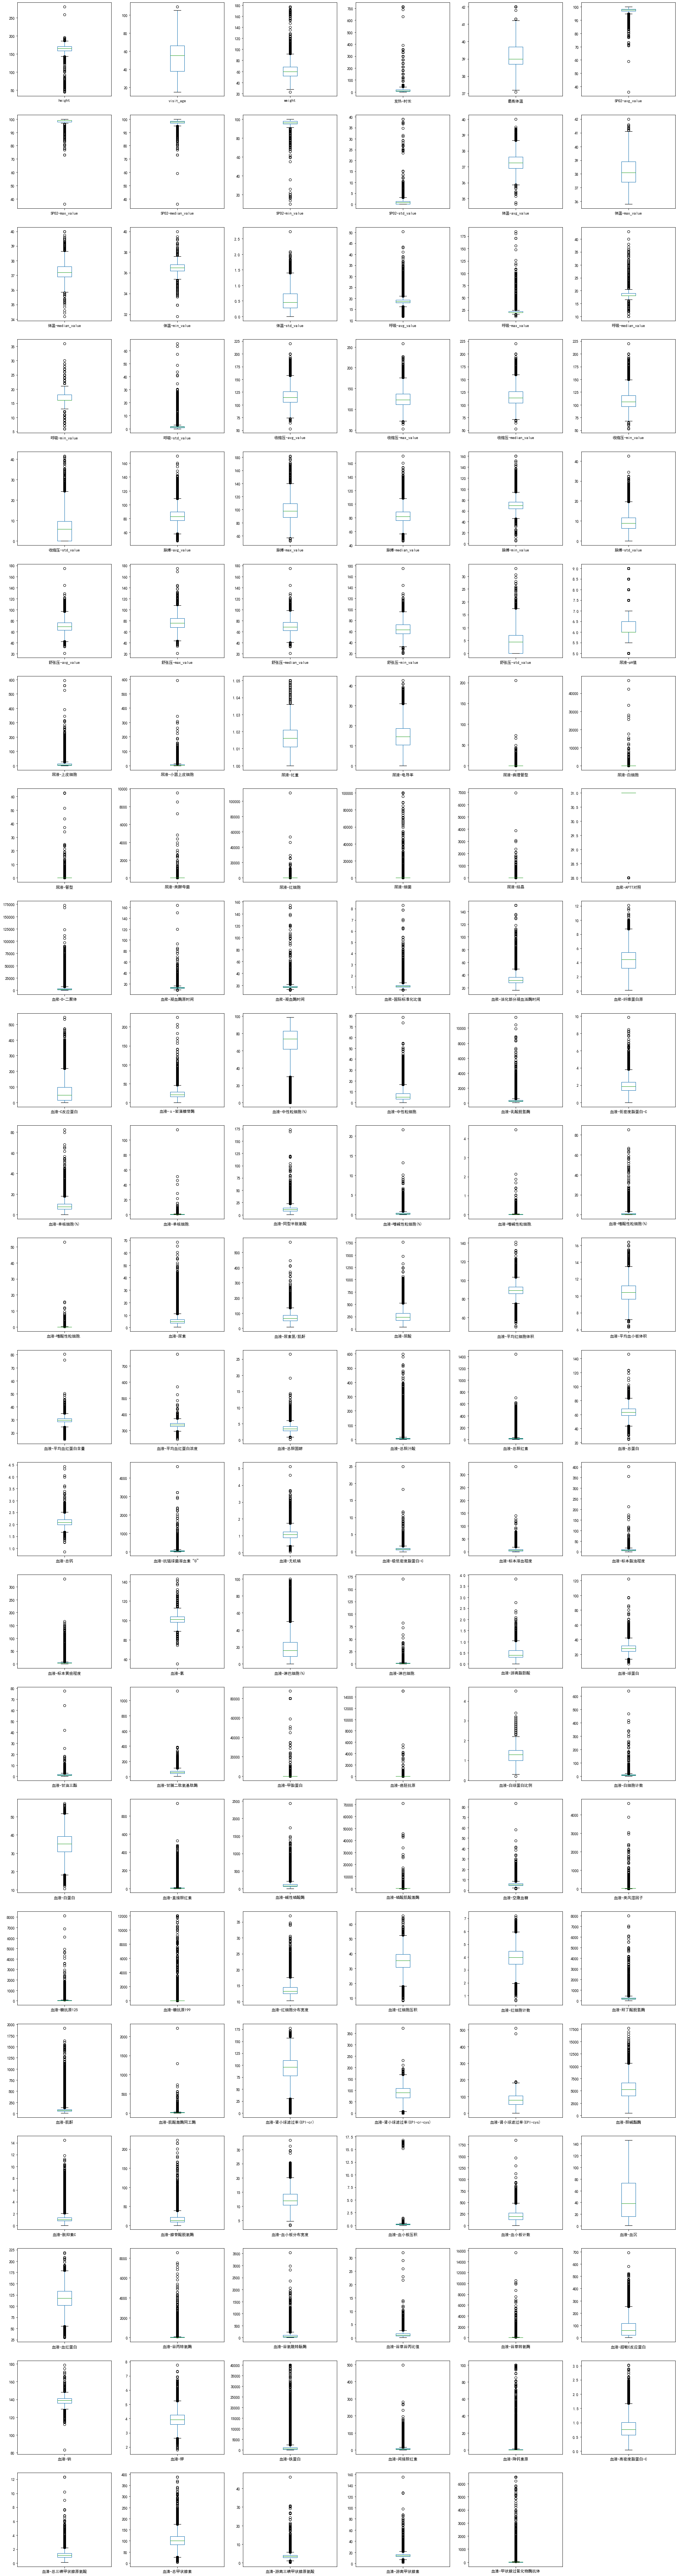

In [20]:
df_X_val = pd.DataFrame(static_data_val, columns=static_val_columns)
df_X_val.plot(kind='box', 
              subplots=True, 
              layout=(23,6),
              sharex=False,
              sharey=False, 
              figsize=(30,120))
plt.savefig(os.path.join(DATA_PATH, '2-Boxplot of static continous data ({0}hours)-after process.png'.format(str(T_LENGTH))), bbox_inches='tight', dpi=400)
plt.show()

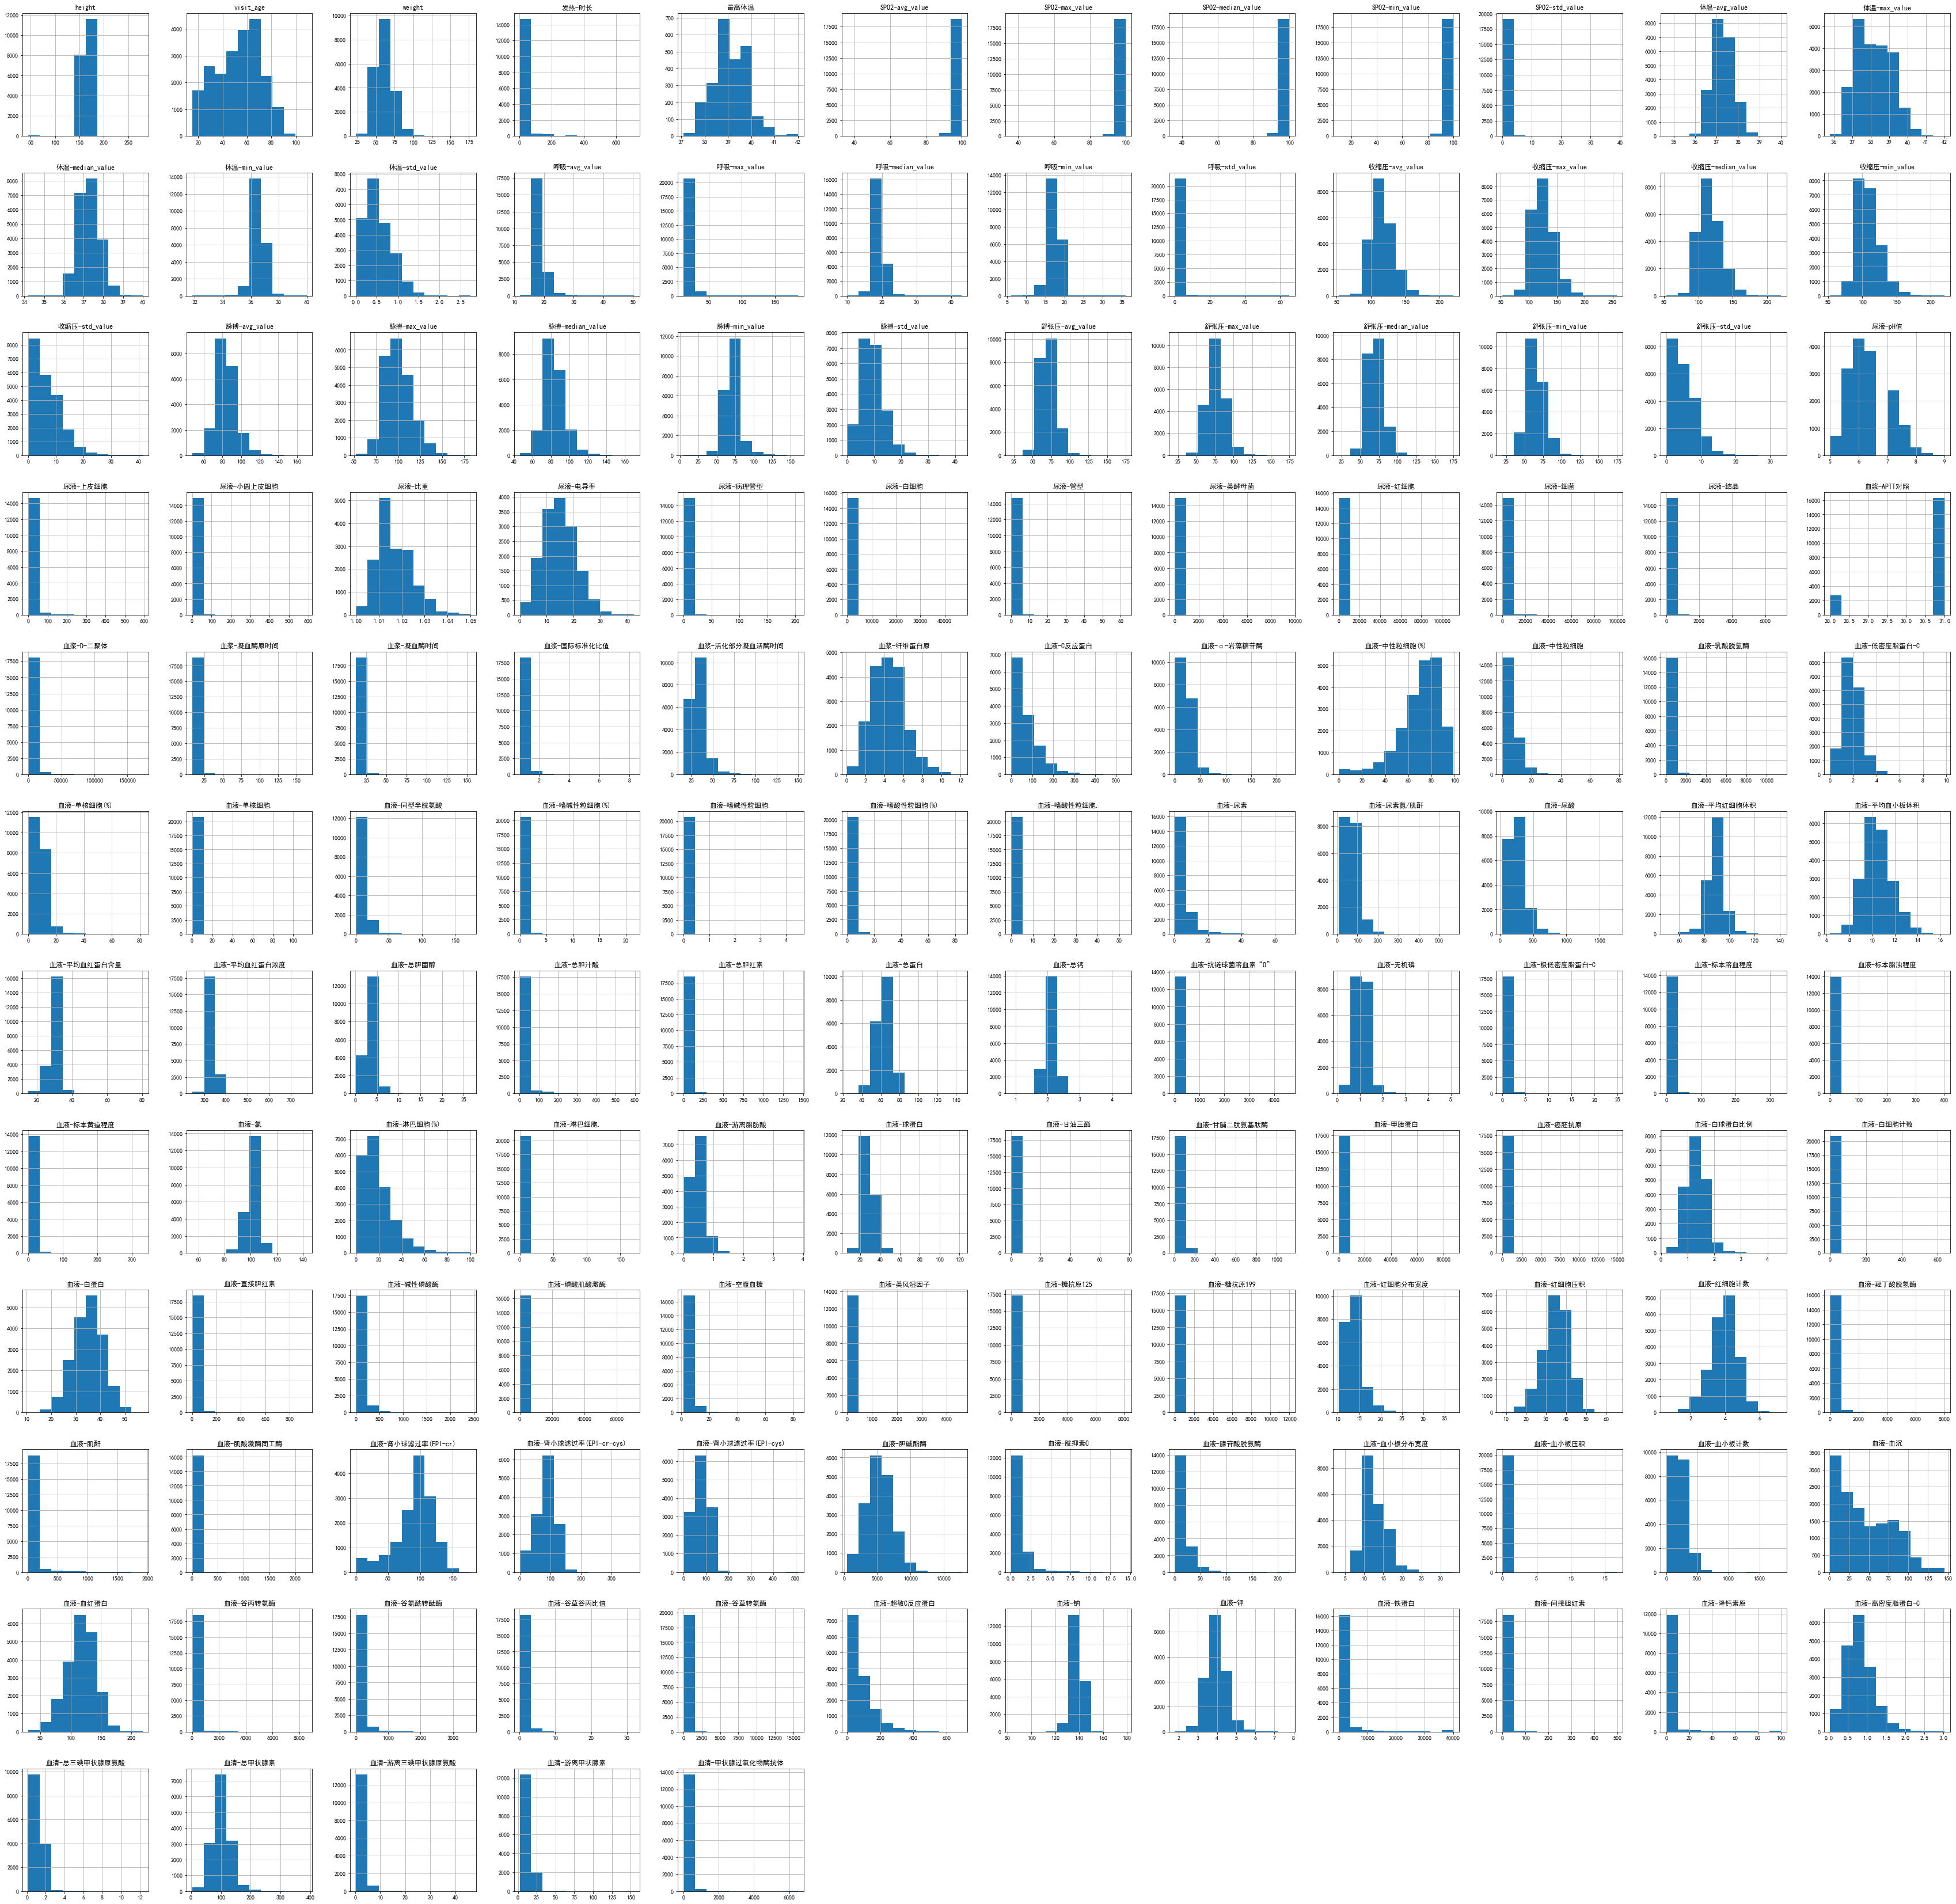

In [21]:
# plot the his
df_X_val.hist(figsize=(60,60))
plt.savefig(os.path.join(DATA_PATH, '2-Hisplot of static continous data ({0}hours)-after process.png'.format(str(T_LENGTH))), bbox_inches='tight', dpi=400)
plt.show()

# plot correlation plot(!!!!cost a lot of time)
# scatter_matrix(df_X_val, figsize=(60,60))
# plt.savefig(os.path.join(DATA_PATH, '2-scatter_matrix of static continous data ({0}hours)-before process.png'.format(str(T_LENGTH))), bbox_inches='tight', dpi=400)
# plt.show()

In [22]:
stat_data = df_X_val.describe()
np.save(os.path.join(DATA_PATH, '2-describe of static continous data ({0}hours)-after process.npy'.format(str(T_LENGTH))), stat_data)
stat_data

,height,visit_age,weight,发热-时长,最高体温,SPO2-avg_value,SPO2-max_value,SPO2-median_value,SPO2-min_value,SPO2-std_value,体温-avg_value,体温-max_value,体温-median_value,体温-min_value,体温-std_value,呼吸-avg_value,呼吸-max_value,呼吸-median_value,呼吸-min_value,呼吸-std_value,收缩压-avg_value,收缩压-max_value,收缩压-median_value,收缩压-min_value,收缩压-std_value,脉搏-avg_value,脉搏-max_value,脉搏-median_value,脉搏-min_value,脉搏-std_value,舒张压-avg_value,舒张压-max_value,舒张压-median_value,舒张压-min_value,舒张压-std_value,尿液-pH值,尿液-上皮细胞,尿液-小圆上皮细胞,尿液-比重,尿液-电导率,尿液-病理管型,尿液-白细胞,尿液-管型,尿液-类酵母菌,尿液-红细胞,尿液-细菌,尿液-结晶,血浆-APTT对照,血浆-D-二聚体,血浆-凝血酶原时间,血浆-凝血酶时间,血浆-国际标准化比值,血浆-活化部分凝血活酶时间,血浆-纤维蛋白原,血液-C反应蛋白,血液-α-岩藻糖苷酶,血液-中性粒细胞(%),血液-中性粒细胞.,血液-乳酸脱氢酶,血液-低密度脂蛋白-C,血液-单核细胞(%),血液-单核细胞.,血液-同型半胱氨酸,血液-嗜碱性粒细胞(%),血液-嗜碱性粒细胞.,血液-嗜酸性粒细胞(%),血液-嗜酸性粒细胞.,血液-尿素,血液-尿素氮/肌酐,血液-尿酸,血液-平均红细胞体积,血液-平均血小板体积,血液-平均血红蛋白含量,血液-平均血红蛋白浓度,血液-总胆固醇,血液-总胆汁酸,血液-总胆红素,血液-总蛋白,血液-总钙,血液-抗链球菌溶血素“O”,血液-无机磷,血液-极低密度脂蛋白-C,血液-标本溶血程度,血液-标本脂浊程度,血液-标本黄疸程度,血液-氯,血液-淋巴细胞(%),血液-淋巴细胞.,血液-游离脂肪酸,血液-球蛋白,血液-甘油三酯,血液-甘脯二肽氨基肽酶,血液-甲胎蛋白,血液-癌胚抗原,血液-白球蛋白比例,血液-白细胞计数,血液-白蛋白,血液-直接胆红素,血液-碱性磷酸酶,血液-磷酸肌酸激酶,血液-空腹血糖,血液-类风湿因子,血液-糖抗原125,血液-糖抗原199,血液-红细胞分布宽度,血液-红细胞压积,血液-红细胞计数,血液-羟丁酸脱氢酶,血液-肌酐,血液-肌酸激酶同工酶,血液-肾小球滤过率(EPI-cr),血液-肾小球滤过率(EPI-cr-cys),血液-肾小球滤过率(EPI-cys),血液-胆碱酯酶,血液-胱抑素C,血液-腺苷酸脱氨酶,血液-血小板分布宽度,血液-血小板压积,血液-血小板计数,血液-血沉,血液-血红蛋白,血液-谷丙转氨酶,血液-谷氨酰转酞酶,血液-谷草谷丙比值,血液-谷草转氨酶,血液-超敏C反应蛋白,血液-钠,血液-钾,血液-铁蛋白,血液-间接胆红素,血液-降钙素原,血液-高密度脂蛋白-C,血清-总三碘甲状腺原氨酸,血清-总甲状腺素,血清-游离三碘甲状腺原氨酸,血清-游离甲状腺素,血清-甲状腺过氧化物酶抗体
count,19759.000000,21521.000000,20022.000000,15441.000000,2396.000000,19252.000000,19252.000000,19252.000000,19252.000000,19252.000000,21520.000000,21520.000000,21520.000000,21520.000000,21520.000000,21521.000000,21521.000000,21521.000000,21521.000000,21521.000000,21410.000000,21410.000000,21410.000000,21410.000000,21410.000000,20711.000000,20711.000000,20711.000000,20711.000000,20711.000000,21410.000000,21410.000000,21410.000000,21410.000000,21410.000000,15920.000000,15057.000000,15070.000000,15873.000000,15070.000000,15026.000000,15392.000000,14795.000000,15032.000000,15357.000000,15050.000000,15026.000000,19060.000000,18630.000000,19063.000000,19058.000000,19062.000000,19054.000000,19056.000000,12981.000000,17934.000000,20872.000000,20798.000000,16418.000000,18078.000000,20859.000000,20794.000000,13754.000000,20822.000000,20803.000000,20825.000000,20799.000000,19968.000000,18198.000000,19953.000000,20908.000000,19993.000000,20907.000000,20908.000000,18144.000000,18497.000000,18790.000000,18791.000000,18976.000000,13604.000000,18976.000000,18069.000000,14046.000000,14046.000000,14046.00000,20119.000000,20873.000000,20799.000000,13754.000000,18782.000000,18144.000000,18502.000000,17438.000000,17435.000000,18782.000000,20911.000000,18791.000000,18788.000000,18765.000000,16386.000000,18030.000000,13608.000000,17348.000000,17433.000000,20884.000000,20908.000000,20908.000000,16386.000000,19969.000000,16261.000000,14685.000000,13156.000000,13157.000000,18499.000000,15083.000000,17887.000000,19993.000000,19994.000000,20896.000000,13858.000000,20909.000000,18790.000000,18765.000000,18756.000000,19726.000000,13268.000000,20119.000000,20112.000000,17406.000000,18781.000000,12488.000000,18100.000000,13939.000000,14479.000000,13927.000000,14469.000000,14143.000000
mean,164.444137,52.749965,60.739037,21.949291,39.167780,97.376200,98.374351,97.477197,96.103418,0.863385,37.282834,38.159192,37.244234,36.515026,0.525636,18.794145,21.527968,18.664769,16.622973,1.591027,116.518479,125.102662,116.215717,108.609668,6.259092,83.839822,99.274782,83.212351,70.449775,9.218354,70.224851,76.277300,70.115787,64.407006,4.510138,6.282443,11.120708,5.980053,1.016552,14.674592,0.454279,59.643521,0.175429,10.787194,93.534792,503.842704,8.454858,30.567156,3407.375631,13.003877,17.945713,1.125509,33.107337,4.440263,65.581175,23.029174,70.346383,6.411627,337.733829,1.922290,8.391836,0.661625,12.035786,0.339991,0.025687,1.299121,0.099334,5.955700,71.850214,259.575402,89.020887,10.488301,29.710910,333.676296,3.557226,14.360275,18.650788,63.322505,2.09

In [23]:
# save the file
np.savez(os.path.join(processed_data_path_raw, 'processed_data_stats.npz'),
         keep_val_idx_list = keep_val_idx_list,
         tsdata_mean = tsdata_mean,
         tsdata_std = tsdata_std,
         N = N, 
         map_vids_list = map_vids_list,
         missing_rate = missing_rate)
np.savez(os.path.join(processed_data_path_raw, 'processed_data.npz'),
         X_t = X_t,
         X_t_mask = X_t_mask,
         T_t = T_t,
         T_t_rel = T_t_rel,
         deltaT_t = deltaT_t,
         static_data_val = static_data_val,
         static_data_cat = static_data_cat,
         static_data_cat_onehot = static_data_cat_onehot,
         label_data = label_data)

### 3 -transform the irregularly sampled time-series data into regularly sampled time-series data
+ with different sample hour
+ with different imputing method(i.e., forward and backward imputing, mean-value computing)

In [24]:
# Get the imputed data for time-series data
hours_list = [(1, T_LENGTH), (2, T_LENGTH), (4, T_LENGTH)]
for n_sample_hour, n_full_hour in hours_list:
    processed_data_path_imputed_fb = os.path.join(processed_data_path, 'imputed_fb' + '_' + str(n_full_hour) + '_' + str(n_sample_hour))
    if not os.path.exists(processed_data_path_imputed_fb):
        os.makedirs(processed_data_path_imputed_fb)

    processed_data_path_imputed_mean = os.path.join(processed_data_path, 'imputed_mean' + '_' + str(n_full_hour) + '_' + str(n_sample_hour))
    if not os.path.exists(processed_data_path_imputed_mean):
        os.makedirs(processed_data_path_imputed_mean)

    print("get X_miss, sampled by {0} in {1} hours".format(n_sample_hour, n_full_hour))
    n_time_step = int(n_full_hour / n_sample_hour)

    # get X_miss first from X_raw_kept and tsraw, (sampled)
    X_miss = np.empty([N], dtype = object)
    T_miss = np.zeros([N], dtype = int)
    for i_n in tqdm(range(N)):
        if tsraw_new[i_n].shape[0] > 1:
            T_miss[i_n] = math.ceil(
                (tsraw_new[i_n][-1] - tsraw_new[i_n][0]) * 1.0 / (60 * 60 * n_sample_hour))
            X_miss[i_n] = np.zeros([T_miss[i_n], n_serial_var], dtype=float)
            for i_t in range(T_miss[i_n]):
                t_idx = np.logical_and(
                    (tsraw_new[i_n]-tsraw_new[i_n][0]) >= i_t*(60*60*n_sample_hour),
                    (tsraw_new[i_n]-tsraw_new[i_n][0]) <= (1+i_t) * (60*60*n_sample_hour))
                X_raw_thist = X_raw_new[i_n][t_idx, :]
                X_miss[i_n][i_t,:] = np.nanmean(X_raw_thist, axis=0)
        # deal with sample with only 1 row records
        elif tsraw_new[i_n].shape[0] == 1:
            T_miss[i_n] = 1
            X_miss[i_n] = np.zeros([T_miss[i_n], n_serial_var], dtype=float)
            for i_t in range(T_miss[i_n]):
                X_miss[i_n][i_t,:] = X_raw_new[i_n][0, :]
        else:
            print("[error] the shape of {}-th sample should be [t*d], but here is empty!".format(i_n))
    print('done!')

    # X_imputed: do forward/backward and mean imputing from X_miss()
    print('get X_imputed')
    X_imputed_fb = deepcopy(X_miss)
    X_imputed_mean = deepcopy(X_miss)
    for i_n in tqdm(range(N)):
        i_n_mean = np.nanmean(X_imputed_fb[i_n], axis=0)
        for i_t in range(1, T_miss[i_n]):
            for i_d in range(n_serial_var):
                if np.isnan(X_imputed_fb[i_n][i_t, i_d]):
                    X_imputed_fb[i_n][i_t, i_d] = X_imputed_fb[i_n][i_t-1, i_d]
        for i_t in range(T_miss[i_n]-2, -1, -1):
            for i_d in range(n_serial_var):
                if np.isnan(X_imputed_fb[i_n][i_t, i_d]):
                    X_imputed_fb[i_n][i_t, i_d] = X_imputed_fb[i_n][i_t+1, i_d]
        # for values which are still none, just impute with 0
        X_imputed_fb[i_n][np.isnan(X_imputed_fb[i_n])] = 0

        # fill the nan with mean value of each column
        for i_t in range(0, T_miss[i_n]):
            for i_d in range(n_serial_var):
                if np.isnan(X_imputed_mean[i_n][i_t, i_d]):
                    X_imputed_mean[i_n][i_t, i_d] = i_n_mean[i_d]
        # for values which are still none, just impute with 0
        X_imputed_mean[i_n][np.isnan(X_imputed_mean[i_n])] = 0

    # get first # hours, for both data and masking
    print('get imputed_tdata_fb')
    imputed_tdata_fb = np.zeros([N, n_time_step, n_serial_var], dtype=float)
    imputed_tdata_fb_masking = np.zeros_like(imputed_tdata_fb, dtype=int)
    for i_n in tqdm(range(N)):
        xx_imp_fb = X_imputed_fb[i_n]
        xx_mis = X_miss[i_n]
        tt_min = min(n_time_step, len(xx_imp_fb))
        assert tt_min > 0

        imputed_tdata_fb[i_n, :tt_min, :] = xx_imp_fb[:tt_min, :]
        imputed_tdata_fb[i_n, tt_min:, :] = imputed_tdata_fb[i_n, tt_min-1, :][None, :]
        imputed_tdata_fb_masking[i_n, :tt_min, :] = (~np.isnan(xx_mis[:tt_min, :])).astype(int)
    print("Done!")

    print('get imputed_tdata_mean')
    imputed_tdata_mean = np.zeros([N, n_time_step, n_serial_var], dtype=float)
    imputed_tdata_mean_masking = np.zeros_like(imputed_tdata_mean, dtype=int)
    for i_n in tqdm(range(N)):
        xx_imp_mean = X_imputed_mean[i_n]
        xx_mis = X_miss[i_n]
        tt_min = min(n_time_step, len(xx_imp_mean))
        assert tt_min > 0

        imputed_tdata_mean[i_n, :tt_min, :] = xx_imp_mean[:tt_min, :]
        imputed_tdata_mean[i_n, tt_min:, :] = imputed_tdata_mean[i_n, tt_min-1, :][None, :]
        imputed_tdata_mean_masking[i_n, :tt_min, :] = (~np.isnan(xx_mis[:tt_min, :])).astype(int)
    print("Done!")

    imputed_tdata_fb_all = np.reshape(imputed_tdata_fb, [N, n_time_step*n_serial_var])
    imputed_tdata_fb_masking_all = np.reshape(imputed_tdata_fb_masking, [N, n_time_step*n_serial_var])

    imputed_tdata_mean_all = np.reshape(imputed_tdata_mean, [N, n_time_step*n_serial_var])
    imputed_tdata_mean_masking_all = np.reshape(imputed_tdata_mean_masking, [N, n_time_step*n_serial_var])

    np.savez(os.path.join(processed_data_path_imputed_fb, 'processed_data_imputed_fb' + '_' + str(n_full_hour) + \
                          '_' + str(n_sample_hour) + '.npz'),
         imputed_tdata_all = imputed_tdata_fb_all, imputed_tdata = imputed_tdata_fb,
         imputed_tdata_masking_all = imputed_tdata_fb_masking_all, 
         imputed_tdata_masking = imputed_tdata_fb_masking,
         static_data_val = static_data_val,
         static_data_cat = static_data_cat,
         label_data = label_data)

    np.savez(os.path.join(processed_data_path_imputed_mean, 'processed_data_imputed_mean' + '_' + str(n_full_hour) + \
                          '_' + str(n_sample_hour) + '.npz'),
         imputed_tdata_all = imputed_tdata_mean_all, imputed_tdata = imputed_tdata_mean,
         imputed_tdata_masking_all = imputed_tdata_mean_masking_all, 
         imputed_tdata_masking = imputed_tdata_mean_masking,
         static_data_val = static_data_val,
         static_data_cat = static_data_cat,
         label_data = label_data)

print("All Done!")

get X_miss, sampled by 1 in 48 hours


100%|██████████| 21521/21521 [01:03<00:00, 339.99it/s]


done!
get X_imputed


100%|██████████| 21521/21521 [00:46<00:00, 463.20it/s]


get imputed_tdata_fb


100%|██████████| 21521/21521 [00:00<00:00, 111509.52it/s]


Done!
get imputed_tdata_mean


100%|██████████| 21521/21521 [00:00<00:00, 108774.99it/s]


Done!
get X_miss, sampled by 2 in 48 hours


100%|██████████| 21521/21521 [00:35<00:00, 608.48it/s]


done!
get X_imputed


100%|██████████| 21521/21521 [00:25<00:00, 845.43it/s] 


get imputed_tdata_fb


100%|██████████| 21521/21521 [00:00<00:00, 129837.49it/s]


Done!
get imputed_tdata_mean


100%|██████████| 21521/21521 [00:00<00:00, 129414.55it/s]


Done!
get X_miss, sampled by 4 in 48 hours


100%|██████████| 21521/21521 [00:18<00:00, 1163.78it/s]


done!
get X_imputed


100%|██████████| 21521/21521 [00:12<00:00, 1678.25it/s]


get imputed_tdata_fb


100%|██████████| 21521/21521 [00:00<00:00, 144340.46it/s]


Done!
get imputed_tdata_mean


100%|██████████| 21521/21521 [00:00<00:00, 146222.94it/s]


Done!
All Done!
